# Information Theory for Neuroscience: Basics

Reproducing experiment of Figure 10 of "A tutorial for information theory in neuroscience"

In [1]:
# imports
%matplotlib inline
from brian2 import *
import dit
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# IT toolbox (for this simulation)

def generate_prob_distribution(observations, var_names=None):
    pmf = {}

    for obs in observations:
        pmf[obs] = pmf.get(obs, 0) + 1

    for obs in pmf:
        pmf[obs] /= len(observations)

    d = dit.Distribution(pmf)
    
    if var_names is not None:
        d.set_rv_names(var_names)
        
    return d

def get_distributions_per_time_bin(observations_per_time_bin, var_names_per_bin=None):
    dists = []
    for i, (obs, var_names) in enumerate(zip(observations_per_time_bin, var_names_per_bin)):
        dists.append(generate_prob_distribution(obs, var_names))
    return dists

def get_mutual_infos(dists):
    return [dit.shannon.mutual_information(d, [0], [1], rv_mode='indices') for d in dists]

def compute_mutual_information(observations_per_time_bin, var_names_per_bin=None):
    dists = get_distributions_per_time_bin(observations_per_time_bin, var_names_per_bin)
    return dists, get_mutual_infos(dists)
                     

In [3]:
# the simulation

def simulation_fig_10(N_monte_carlo=100, sim_inactive=True):
    start_scope()
    
    # simulation parameters
    duration = 1000
    time_bin_size = 50
    
    nb_bins = duration//time_bin_size
    observations = [[] for bin_index in range(nb_bins)]
    
    I_max = 500
    
    # Neuron parameter
    group_namespace = {
        'I_max': I_max,
        'I_active': TimedArray([0, I_max, I_max, 0], dt=(duration//4)*ms),
        'I_weak': TimedArray([0, I_max/2, I_max/2, 0], dt=(duration//4)*ms),
        'I_inactive': TimedArray([0], dt=duration*ms),
        'a': 0.03, 'b': -2, 'c': -50, 'd': 100,
        'vr': -60, 'vt': -40, 'vpeak': 35,
        'C': 100, 'k': 0.7, 'tau': 1*ms,
        'input_func': TimedArray([0], dt=duration*ms),
    }
    model =\
    '''
    dv/dt = (k*(v-vr)*(v-vt) - u + I)/(C*tau) + 5*xi*sqrt(1/tau): 1
    du/dt = a*(b*(v - vr) - u)/tau : 1
    I = input_func(t) : 1
    spike_nb: 1
    '''
    reset =\
    '''
    spike_nb += 1
    v = c
    u += d
    '''
    peak_threshold = 'v>vpeak' 
    
    neuron = NeuronGroup(1, model, threshold=peak_threshold, reset=reset, method='euler', namespace=group_namespace)
    neuron.v = neuron.namespace['vr']
    neuron.u = neuron.namespace['b']*neuron.v
    statemon = StateMonitor(neuron, ['v', 'I'],record=0)
    
    # Network parameters
    @network_operation(dt=time_bin_size*ms)
    def update_time_bin(t):
        if t/ms == 0: return
        obs = tuple([neuron.namespace['input_func'](t-defaultclock.dt)] + list(neuron.spike_nb))  # <---- change to > 2 (median) for equal count bins
        bin_index = int((t/ms)/time_bin_size)
        observations[bin_index-1].append(obs)
        
        neuron.spike_nb = 0
    
    network = Network(neuron, statemon, update_time_bin)
    network.store()
    
    
    # First, simulate with strong input
    neuron.namespace['input_func'] = neuron.namespace['I_active']
    network.run(duration*ms + defaultclock.dt)
    plot_neuron_and_input(statemon, 'I_active')
    
    statemon.active = False
    for _ in range(N_monte_carlo-1):
        network.restore()
        network.run(duration*ms + defaultclock.dt)
    
    # The, with weak/without input
    network.restore()
    statemon.active = True
    
    if sim_inactive:
        new_input = 'I_inactive'
    else:
        new_input = 'I_weak'
        
    neuron.namespace['input_func'] = neuron.namespace[new_input]
    network.run(duration*ms + defaultclock.dt)
    
#     plot_neuron_and_input(statemon, new_input)
    
    statemon.active = False
    for _ in range(N_monte_carlo-1):
        network.restore()
        network.run(duration*ms + defaultclock.dt)
    
    return observations

In [10]:
def plot_neuron_and_input(statemon, plt_title):
    fig, ax1 = subplots(figsize=(10,4))
    color = 'tab:blue'
    ax1.set_xlabel('time (s)')
    ax1.set_xticks(arange(0, 1050, 50))
    ax1.set_ylabel('v', color=color)
    ax1.plot(statemon.t/ms, statemon.v[0], color=color, lw=1)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title(plt_title)
    for t in arange(0, 1050, 50):
        ax1.axvline(t, ls='--', c='C1', lw=1)
    
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('I', color=color)
    ax2.set_ylim([-10, 510])
    ax2.plot(statemon.t/ms, statemon.I[0], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    savefig('neuro-basics-membrane.png')
    
def plot_mutual_information(muts):
    fig, ax1 = subplots(figsize=(4,4))
    title('stimulus encoding')
    plot(arange(len(muts))*50 + 50, muts, 'o--')
    ylabel('mutual_information(I, Neuron)')
    ylim([-0.1,1.1])
    savefig('neuro-basics-encoding.png')
    
def plot_dist(d):
    d.make_dense()
    fig = figure(figsize=(6, 6))
    ax1 = fig.add_subplot(111, projection='3d')

    I_space = []
    spk_space = []

    for I, spk_nb in d.outcomes:
        I_space.append(I)
        spk_space.append(spk_nb)

    n = len(I_space)
    prob = zeros(n)

    dI_space = 50*ones(n)
    dspk_space = 0.75*ones(n)
    dprob = d.pmf

    ax1.bar3d(I_space, spk_space, prob, dI_space, dspk_space, dprob, shade=True)

    ax1.set_xlabel('Stimulus state (Off = 0, On = 500)')
    ax1.set_ylabel('Spike count')
    ax1.set_zlabel('joint probability')
    fig.tight_layout()
    savefig('neuro-basics-dist.png')

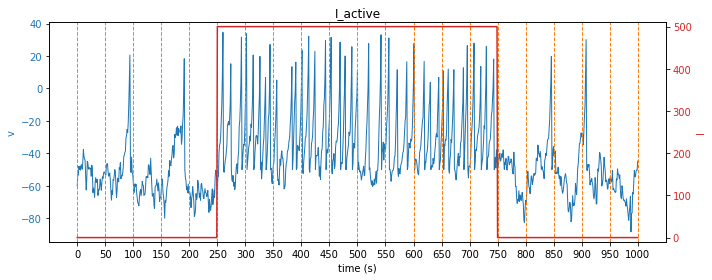

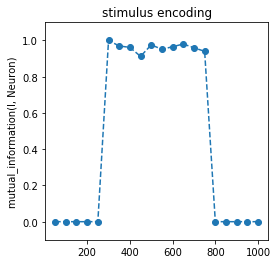

In [6]:
defaultclock.dt = 1*ms
observations = simulation_fig_10(100)
dists, muts = compute_mutual_information(observations, var_names_per_bin=[['I','Spk_state_bin_'+str(i)] for i in range(len(observations))])
plot_mutual_information(muts)

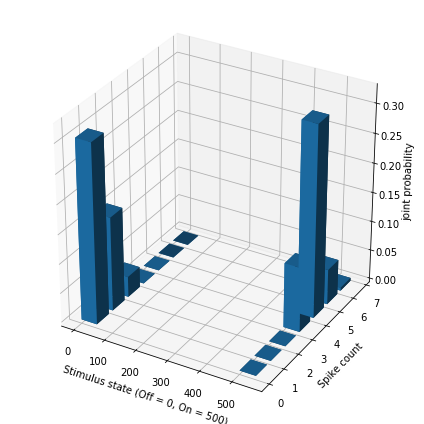

In [11]:
# distribution of (spike_count, stimulus)
plot_dist(dists[5])